In [5]:
import numpy as np
import os
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import MaxPooling2D, Dropout,Flatten, Dense, Activation, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
import random
from matplotlib.image import imread
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
dir_path = '.\data'
os.listdir(dir_path)

['test', 'train']

In [3]:
train_path = f"{dir_path}\\train\\"
test_path = f"{dir_path}\\test\\"
os.listdir(test_path)

['without_mask', 'with_mask']

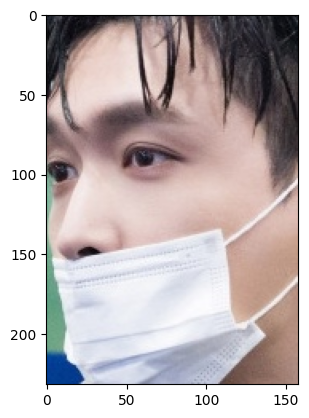

In [6]:
sample = random.choice(os.listdir(train_path + 'with_mask'))
parasite_cell = train_path + 'with_mask\\'+ sample
plt.imshow(plt.imread(parasite_cell))

In [7]:
height=[]
width=[]
for image in os.listdir(test_path+'with_mask'):
    image = imread(test_path+'\\with_mask\\'+image)
    h, w, colors = image.shape
    height.append(h)
    width.append(w)

In [8]:
np.mean(height)

373.4146341463415

In [9]:
np.mean(width)

351.9024390243902

In [10]:
image_size = (350, 350, 3)

## Transfer Learning.
- Transfer learning is a machine learning method where we reuse a pre-trained model as the starting point for a model on a new task.
- In CNNs we can use the feature extraction layers (Convolution Layers) from a model that has already been trained.
- This approach enables us to keep the pretrained weights for feature extraction layers, which means we only need to train the prediction layers(Fully connected layer).
- There are many established CNN architecture for image classification that you can use as the base model.

#### Advantages of Transfer Learning
- It saves time and resources. Most machine learning problems involve training a large amount of data. This type of labeled training data takes more time. However, in transfer learning most models are pre-trained, which reduces the size of training data.
- It improves the efficiency of a model while training. Developing machine learning models to solve complex problems is time-consuming. With transfer learning, you don’t need to create a model from scratch. You can reuse the developed model by transferring its knowledge.
- Instead of using different algorithms to solve new problems, transfer learning provides a more generalized way of solving the problem.

#### Load the VGG16 model
- Initialize the weights and input size.
- **include_top=False** - Means discard the weights for the input and output layers from the model.

In [11]:
base_model = VGG16(weights = 'imagenet', include_top=False, input_shape = image_size)

In [12]:
# Model input
base_model.input

<KerasTensor: shape=(None, 350, 350, 3) dtype=float32 (created by layer 'input_1')>

#### Don't retrain the layers in the model

In [13]:
for layer in base_model.layers:
    layer.trainable = False

#### Add the fully connected Layer

In [14]:
headmodel = base_model.output
headmodel = MaxPooling2D(pool_size=(7,7))(headmodel)
headmodel = Flatten(name = 'Flatten')(headmodel)
headmodel = Dense(128, activation='relu')(headmodel)
headmodel = Dropout(0.5)(headmodel)
headmodel = Dense(2,activation='softmax')(headmodel)

model = Model(inputs = base_model.input,outputs=headmodel)

In [15]:
# Model Summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 350, 350, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 350, 350, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 350, 350, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 175, 175, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 175, 175, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 175, 175, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 87, 87, 128)       0     

#### Callbacks
- **Callbacks** are objects in tensorflow & keras that are designed to monitor the model performance in metrics between epochs.
- **Early stopping** Stop training when a monitored metric has stopped improving. Assuming the goal of a training is to minimize the loss.
- **monitor='val_loss'** to use validation loss as performance measure to terminate the training.</p>
    
- **patience=0:** is the number of epochs with no improvement. The value 0 means the training is terminated as soon as the performance measure gets worse from one epoch to the next.

In [16]:
early_stop = EarlyStopping(monitor='val_loss', patience = 4)

In [17]:
learning_rate = 0.001
Epochs = 20
batch = 16
optimizer = Adam(lr = learning_rate)
model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

#### Data augmentation
- We use the **preprocess_input** because it conatins the same preprocessing as in the model training.
- Other parameters are used to generate different variations of the same images. 
- This increases the overall number of images for training as well as reduce overfitting.

In [18]:
image_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range = 20,
    zoom_range = 0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range= 0.15,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

In [19]:
train_data = image_generator.flow_from_directory(
    train_path,
    target_size=image_size[:2],
    color_mode= "rgb",
    batch_size=batch,
    class_mode="categorical"
)

Found 3836 images belonging to 2 classes.


In [20]:
test_data = image_generator.flow_from_directory(
    test_path,
    target_size=image_size[:2],
    color_mode= "rgb",
    batch_size=batch,
    class_mode="categorical"
)

Found 328 images belonging to 2 classes.


#### Train model

In [21]:
result = model.fit(
    train_data,
    steps_per_epoch = len(train_data)/batch,
    validation_data=test_data,
    validation_steps=len(test_data)/batch,
    epochs = Epochs,
    callbacks = [early_stop]
)

Epoch 1/20
15/15 [==============================] - 248s 16s/step - loss: 8.0798 - accuracy: 0.6125 - val_loss: 1.5363 - val_accuracy: 0.8750
Epoch 2/20
15/15 [==============================] - 223s 15s/step - loss: 4.3598 - accuracy: 0.7708 - val_loss: 0.6962 - val_accuracy: 0.8750
Epoch 3/20
15/15 [==============================] - 299s 20s/step - loss: 2.2983 - accuracy: 0.8458 - val_loss: 0.3499 - val_accuracy: 0.9688
Epoch 4/20
15/15 [==============================] - 309s 21s/step - loss: 1.6308 - accuracy: 0.8390 - val_loss: 0.9153 - val_accuracy: 0.8750
Epoch 5/20
15/15 [==============================] - 287s 19s/step - loss: 1.2272 - accuracy: 0.8708 - val_loss: 0.1105 - val_accuracy: 0.9688
Epoch 6/20
15/15 [==============================] - 234s 16s/step - loss: 0.7937 - accuracy: 0.9000 - val_loss: 0.5039 - val_accuracy: 0.9688
Epoch 7/20
15/15 [==============================] - 275s 19s/step - loss: 0.8360 - accuracy: 0.8917 - val_loss: 0.0857 - val_accuracy: 0.9688
Epoch 

### Save Model

In [ ]:
model.save("model.h5")

## END